# Programming exercise 8: The AKLT model and matrix product states

Due on Monday, 24.12.2018, 23.59h

__This exercise sheet has been solved by:__ Mathieu Kaltschmidt and Carl von Randow

### Total: 100 points

In [22]:
# load standard libraries
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 9

### Exercise 1: Solving the AKLT model with exact diagonalization (25 points)

This time we want to study a quantum many-body model for spins known as the AKLT model which was introduced in the 80's to explore the Haldane conjecture(see https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799). It has a couple of remarkable features that will allow us to use it as playground for testing the basic ideas surrounding matrix product states. As additional practice on how to build general spin models and exact diagonalization, we will start by solving it here by numerical means and then compare the result to some theoretical predictions. You can use some of the code from the last exercise as a basis but make sure to modify the operators as now we are working with spin 1!  

As mentioned, this is a spin 1 model and it lives in a one dimensional chain with periodic boundary conditions (using the correct boundary condition is critical here) and the Hamiltonian is given by:

$$
H=J\sum_{i=0}^{N-1}\left(\frac{1}{3} +\frac{1}{2}S^{(i)}\cdot S^{(i+1)}+\frac{1}{6}(S^{(i)}\cdot S^{(i+1)})^2\right)
$$
Remenber that, due to the periodic boundary conditions, the Nth spin is identified with 0th spin. $S^{(i)}$ denotes the vector of spin sperators $(S_x^{(i)}, S_y^{(i)}, S_z^{(i)})$. It might be convenient to use the following representation for the spin their products:
$$
S^{(i)}\cdot S^{(i+1)} = S_z^{(i)} S_z^{(i+1)}+\frac{1}{2}\left(S_+^{(i)}S_-^{(i+1)}+S_-^{(i)}S_+^{(i+1)}\right)
$$
where the relevant spin 1 spin operators are $S_z=-|-1\rangle\langle-1| + |+1\rangle\langle+1|$, $S_+=\sqrt{2}(|+1\rangle\langle 0| + |0\rangle\langle -1|)$ and $S_- = S_+^\dagger$ (with $|s\rangle$ denoting the basis states in the $S_z$ eigenbasis).

Build the Hamiltonian in the standard product basis ($J$ is just a global energy scale and can be set to 1).

First you can test your implementation by calculating the ground state energy and making sure it is zero as this is the theoretical prediction. Another test is the magnetization on the z direction which should also be zero.

Once you are confident that your code is working you should compute the energy gap between ground and first excited state for a couple of system sizes $N$ and see how it behaves. Is the system gapped? This question is directly related to the Haldane conjecture.

Finally, compute the correlation function $\langle S_z^{(i)}S_z^{(i+r)} \rangle$ as a function of $r$ and compare to the theoretical result:
$$
\langle S_z^{(i)}S_z^{(i+r)}\rangle \propto \left(\frac{-1}{3}\right)^r
$$

It probably won't look so good as the exact diagonalization is not the best tool to study this but you should get some agreement.


Optional: Investigate what happend for open boundary conditions and see if there is any qualitative difference.

## Solution: 

In [2]:
#Predefined values
(hbar, J) = (1, 1)

In [3]:
SpinUp, SpinZero, SpinDown = hbar * np.eye(3)

#Building the Spin Operators as Sparse matrices
Sz = sp.csr_matrix(-np.outer(SpinDown, SpinDown) + np.outer(SpinUp, SpinUp))
SPlus = sp.csr_matrix(np.sqrt(2)*(np.outer(SpinUp, SpinZero) + np.outer(SpinZero, SpinDown)))
SMinus = sp.csr_matrix(np.transpose(SPlus))

In [4]:
#Building the Single Spin Operators
def SingleSpinOps(N):
    
    Sz_i = [sp.kron( sp.kron( sp.identity(3**(N-i-1)), Sz), sp.identity(3**i)) for i in range(N)] 
    SPlus_i = [sp.kron( sp.kron( sp.identity(3**(N-i-1)), SPlus), sp.identity(3**i)) for i in range(N)]
    SMinus_i = [sp.kron( sp.kron( sp.identity(3**(N-i-1)), SMinus), sp.identity(3**i)) for i in range(N)] 
    
    return np.array(Sz_i), np.array(SPlus_i), np.array(SMinus_i)

#Hamiltonian for the Transverse Field Ising model with periodic boundary conditions
def buildH(N, Sz_i, SPlus_i, SMinus_i):
    H = J * N/3 * sp.identity(3**N)
    for i in range(N):
        prod = Sz_i[i] @ Sz_i[(i+1)%N] + 1/2*( SPlus_i[i] @ SMinus_i[(i+1)%N] + SMinus_i[i] @ SPlus_i[(i+1)%N])
        H += 1/2 * prod + 1/6 * prod @ prod
    return H

### Ground state energy

In [51]:
#Some Test values for N (ATTENTION: for N>14 the computation time is very high)
Nvals = np.arange(3,19,1, dtype = int)

for N in Nvals[:-6]:
    Sz_i, SPlus_i, SMinus_i = SingleSpinOps(N)
    
    #Calculating the ground state energy
    H = buildH(N, Sz_i, SPlus_i, SMinus_i)
    
    #Determining the energy of the ground state
    E0 = sLA.eigsh(H, k=3, which='SA')[0][0]
    print('The ground state energy for N = {} has been determined to'.format(N), E0)
    print()    

The ground state energy for N = 3 has been determined to 1.23291653133e-16

The ground state energy for N = 4 has been determined to 4.69773922259e-16

The ground state energy for N = 5 has been determined to -4.46700773281e-17

The ground state energy for N = 6 has been determined to -1.88202881119e-15

The ground state energy for N = 7 has been determined to -5.12742189082e-16

The ground state energy for N = 8 has been determined to -5.00643790074e-16

The ground state energy for N = 9 has been determined to -9.3558354412e-16

The ground state energy for N = 10 has been determined to 2.35367766379e-16

The ground state energy for N = 11 has been determined to -7.56592117818e-16

The ground state energy for N = 12 has been determined to -1.20877827803e-16



### Discussion:
These values can be considered as zero and therefore they show that our calculation of the ground state energy is valid.

### Energy gap for different $N$

In [6]:
#Initialization
gap = []
#Calculating the gap for all the N values
for N in Nvals[:-6]:
    Sz_i, SPlus_i, SMinus_i = SingleSpinOps(N)
    H = buildH(N, Sz_i, SPlus_i, SMinus_i)
    energies = sLA.eigsh(H, k=2,which="SA")[0]
    gap.append(energies[1]-energies[0])

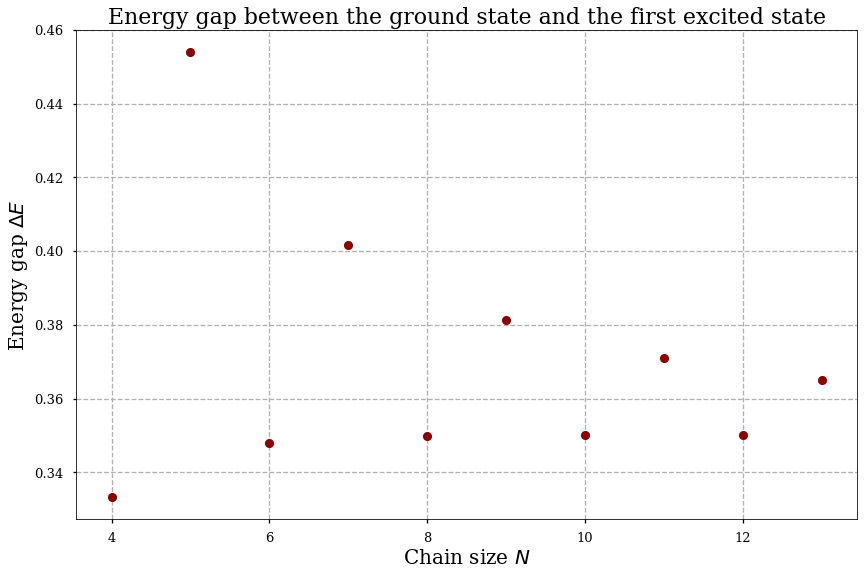

In [8]:
#Plotting the result
plt.plot(Nvals[:-5], gap, linestyle = ' ', color = 'darkred', marker = 'o')
plt.title(r'Energy gap between the ground state and the first excited state', size = 22)
plt.ylabel(r'Energy gap $\Delta E$', size = 20)
plt.xlabel(r'Chain size $N$', size = 20)
plt.grid(True, linestyle = 'dashed')

### Discussion:
As one would expect from the fact that we are observing a Spin-1 Heisenberg chain, there is an energy gap between the first excited state and the ground state. In the limit of large $N$ the value of the energy difference converges to a value $\sim 0.36 \ [AU] $

## Spin correlation function

In [78]:
#Theoretical expectation
def SpinCorrelationTheo(const,r):
    return const * (-1/3)**r

#Numerical calculation
def SpinCorrelationNum(i,r,N):
    if i < 0 or i > N:
        raise ValueError('Index out of range')
    
    (Sz_i1, Sz_i2) = (SingleSpinOps(N)[0][i], SingleSpinOps(N)[0][i+r])
    corr = Sz_i1 @ Sz_i2
  #there is somting missing here because we were not sure how exactly the determination of the expectation values works

### Discussion

-

### Exercise 2: Entanglement in the phase diagram (25 points)

Now we are going to look at entanglement in the AKLT model but to make things more interesting we add a paramenter $\theta$ to the Hamiltonian:
$$
H=J\sum_{i=0}^{N-1}\left(\frac{cos(\theta)}{3 cos(\theta_{0})} +\frac{cos(\theta)}{2 cos(\theta_{0})}S^{(i)}\cdot S^{(i+1)}+\frac{sin(\theta)}{2 cos(\theta_{0})}(S^{(i)}\cdot S^{(i+1)})^2\right)
$$
where $\theta_0 = \text{arctan}(1/3)$ is a special angle that allow us to go back to the original Hamiltonian with $\theta=\theta_0$.


Study what happens to the gap of the system as you change $\theta$, moving away from $\theta_0$, and interpret your results. After this you should look at the entanglement of the ground state for different $\theta$ taking into account your conclusions about the gap. What happens to the entanglement entropy and the schmidt rank as $\theta$ changes?

Tip: a nice trick to compute partial traces is to use the function reshape() as it allows you to rewrite your state as a matrix in the way required for a Schmidt decomposition. After that all you need to do to get the entanglement spectrum is perform a svd (also available in the usual places) and look at the singular values.

## Solution:

In [52]:
#Building the modified Hamiltonian
def buildH_mod(N, Sz_i, SPlus_i, SMinus_i, theta):
    #Initialization
    H = J * N * np.cos(theta)/(3 * np.cos(np.arctan(1/3))) * sp.identity(3**N)
    for i in range(N):
        prod = Sz_i[i] @ Sz_i[(i+1)%N] + 1/2 * (SPlus_i[i] @ SMinus_i[(i+1)%N] + SMinus_i[i] @ SPlus_i[(i+1)%N])
        H += np.cos(theta)/(2*np.cos(np.arctan(1/3)))* prod + np.sin(theta)/(6 * np.cos(np.arctan(1/3))) * prod @ prod
    return H

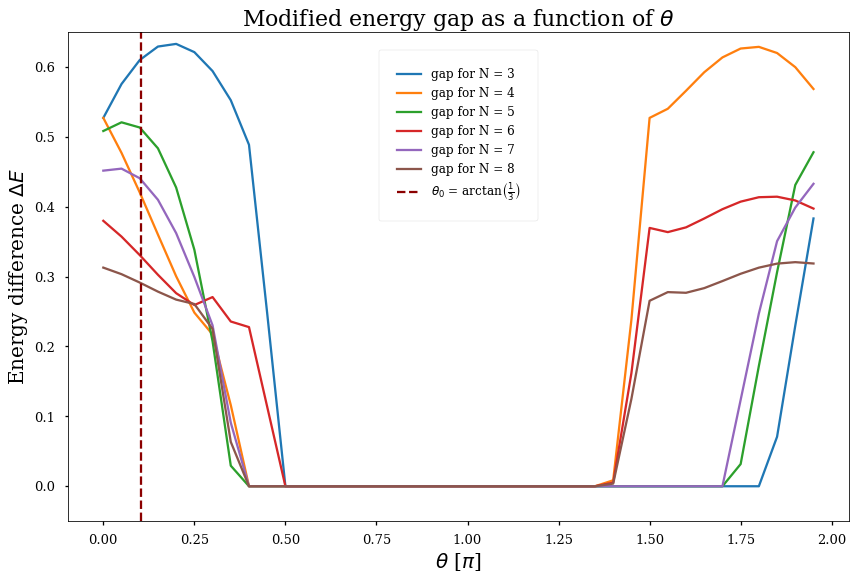

In [53]:
thetaVals = np.arange(0,2*np.pi,np.pi/20)

#Comparing the result for different N
gap_all = []
states_all = []
for N in Nvals[:6]:
    Sz_i, SPlus_i, SMinus_i = SingleSpinOps(N)
    gap = []
    statesN = []
    #Trying different thetas
    for theta in thetaVals:
        H = buildH_mod(N, Sz_i, SPlus_i, SMinus_i, theta)
        energies, states = sLA.eigsh(H, k=3, which="SA")
        #Energy gap
        gap.append(energies[1] - energies[0])
        #Corresponding states
        statesN.append(states)
        
    #Storing all the results
    gap_all.append(gap)
    states_all.append(statesN)
    
    #Plotting the result
    plt.plot(thetaVals/np.pi, gap, label= 'gap for N = {}'.format(N))
    
#Setting up the Plot
plt.plot([np.arctan(1/3)/np.pi]*2, (-0.05,0.7), linestyle = 'dashed', color = 'darkred', 
         label = r'$\theta_0$ = arctan$\left(\frac{1}{3}\right)$')
plt.xlabel(r'$\theta$ [$\pi$]', size = 20)
plt.ylabel(r'Energy difference $\Delta E$', size = 20)
plt.ylim(-0.05,0.65)
plt.title(r'Modified energy gap as a function of $\theta$', size = 22)
plt.legend(fontsize='large', borderpad=1.5, borderaxespad=1.5)

### Discussion:

As one can easily observe in the plot above the gap vanishes for $\theta \sim 0.5 - 1.35$. This is the case for all the values for $N$ we chose. For higher $N$ the area where the gap vanished is more precisely defined.

### Schmidt rank and Entanglement entropy

In [54]:
#Further analysis using the respective ground state

#Test case: N=3, Theta = 0
Psi = states_all[0][0][:,0]

#Calculating the Schmidt rank 
def SchmidtRank(state):
    #Correct reshaping
    """
    We are not sure how exactly one chooses the value for M to obtain a useful 
    matrix representation of the state.
    """
    n = len(state)
    M = 1 #test value
    reshape = np.reshape(state, (M, N-M))
    
    #Obtain U, S and V matrix
    U, S, V = LA.svd(reshape)
    
    #Counting non-zero elements
    for i in range(len(S)):
        rank = 0
        while np.abs(S[i]) > 2e-10:  #some value near zero to filter out non-counting values
            rank += 1
    return rank
    
def EntanglementEntropy(state):
   #Correct reshaping
    """
    We are not sure how exactly one chooses the value for M to obtain a useful 
    matrix representation of the state.
    """
    n = len(state)
    M = 1 #test value
    reshape = np.reshape(state, (M, N-M))
    
    #Obtain U, S and V matrix
    U, S, V = LA.svd(reshape)
   
    #Calculating the entropy
    for i in range(len(S)): 
        entropy = 0
        if S[i] < 2e-10: #some value near zero to filter out non-counting values
            raise ValueError('Negative value in log encountered!')
        entropy += S[i]**2 * np.log(S[i]**2) 
    return - entropy

[  9.38133383e-19  -6.45647245e-17  -7.79697746e-17   1.62471731e-17
   5.99723679e-17  -4.08248290e-01   6.52311417e-17   4.08248290e-01
   1.96821300e-17   2.59035850e-17   3.45315566e-17   4.08248290e-01
  -1.26065406e-16  -7.47376007e-18   2.65802882e-17  -4.08248290e-01
  -3.16239231e-17  -3.29158517e-17   7.11815846e-17  -4.08248290e-01
  -1.63676421e-17   4.08248290e-01  -9.06306434e-18   3.39068053e-17
   5.05048586e-17  -3.17844493e-18  -3.29238218e-17]


### What happens to the Schmidt rank and the entropy for different values for $\theta$ ?

In [ ]:
#Determining the results for all theta values
schmidt_ranks = []
entropies = []

for theta in range(len(thetaVals)):
    #Here: N=3
    Psi = states_all[0][theta][:,0] 
    schmidt_ranks.append(SchmidtRank(Psi))
    entropy.append(EntanglementEntropy(Psi))    

In [ ]:
#Plotting the results for the Schmidt decomposition
plt.plot(thetaVals/np.pi, schmidt_ranks, label= 'Schmidt rank', color = 'darkred')

plt.xlabel(r'$\theta$ [$\pi$]', size = 20)
plt.ylabel(r'Corresponding Schmidt rank', size = 20)
plt.title(r'Impact on the Schmidt rank for varying $\theta$', size = 22)

In [ ]:
#Plotting the results for the entropy
plt.plot(thetaVals/np.pi, entropies, label= 'Entanglement entropy', color = 'darkred')

plt.xlabel(r'$\theta$ [$\pi$]', size = 20)
plt.ylabel(r'Entanglement entropy', size = 20)
plt.title(r'Impact on the Entanglement entropy for varying $\theta$', size = 22)

### Discussion:

We could not perform the plots in this part exercise of the exercise because we did not know how to reshape the state. All the functions we wrote should compute the correct observables but because we did not know the right method to compute the svd, there is unfortunately no output.

### Exercise 3: MPS description (50 points)

Finally we will use the MPS machinery and explain why we chose to study the AKLT model (besides the fact that it is a pretty cool model :)). Usually for any given Hamiltonian it is necessary to apply a (complicated) procedure to find a good MPS aproximation for the ground states but the AKLT ground states is special in that it admits an exact MPS description so we can directly apply the tensor network techniques to it! The representation only requires bond dimension 2 and is given by the following 2x2 matrices:
$$
A_{+1}=\sqrt{\frac{2}{3}} \sigma_+\\
A_{0}=-\sqrt{\frac{1}{3}} \sigma_z\\
A_{-1}=-\sqrt{\frac{2}{3}} \sigma_-\\
$$

Show that this really gives the ground state by comparing it to the states you got from exact diagonalization. To do so you should use the expression for MPS ansatz to reconstruct the corresponding state in your basis
$$
|\psi_{\text{mps}}\rangle = \sum_{s_i} Tr(A_{s_0}A_{s_1}\dots A_{s_{N-1}})|s_0 s_1 \dots s_{N-1}\rangle
$$
and compute the overlap $\langle\psi_{\text{ed}}|\psi_{\text{mps}}\rangle$ with the exact diagonalzation ground state. Of course, this is not very smart as we are using our efficiennt MPS representation to reconstruct the inefficient ED representation, but it is a good sanity check nonetheless. 

You might notice a small deviation on the overlap. This comes from the fact that the MPS state is not normalized and you can see this by computing the norm directly from the matrices:
$$
\langle\psi_{\text{mps}}|\psi_{\text{mps}}\rangle = Tr(E^n)
$$
where
$$
E = \sum_s A_s\otimes A_s^*\\
$$
is the local matrix corresponding to the identity operator. To speed up this calculation you can diagonalize E so that you only need to compute powers of the eigenvales and not the actual matrix. Show that the deviation from 1 is small and vanishes exponentially for large systems.

Now, for the real benefits of the MPS, let's compute the correlation function $\langle S_z^{(i)}S_z^{(i+r)}\rangle$ from exercise 1. This can be done for very large systems by simply replacing two E matrices in the expression for the norm with
$$
E_z = \sum_{s,s'}\langle s|S_z|s'\rangle A_s\otimes A_{s'}^*
$$
which is the local matrix for $S_z$. Think about the correct position where the $E_z$ should go and use this to compute the correlation function. Compare the results to the theoretical prediction mentioned in the first exercise.

Optional: The AKLT model has a hidden order that manifests it self through a string operator:
$$
\langle S_z^{(i)}\,\exp\left[\sum_{i<k<j}i \pi S_z^{(k)}\right] \,  S_z^{(j)}\rangle
$$
Compute this order parameter and show that it maintains a constant value for $|i-j|>2$

In [66]:
#Matrix 
APlus = sp.csr_matrix(np.array([[0, np.sqrt(2/3)], [0,0]]))
ANull = sp.csr_matrix(-1/np.sqrt(3) * np.array([[1,0], [0,-1]]))
AMinus = sp.csr_matrix(np.array([[0,0],[-np.sqrt(2/3),0]]))

AMatrix = [APlus, ANull, AMinus]

In [82]:
N = 4 #some test value
mps_states = []
traces = []
for x in range(3**N):
    state = np.array([(x % (3**(i+1)) ) // (3**i) for i in np.arange(N-1, -1, -1)])
    
    
    matrices = [AMatrix[index].todense() for index in state]
    tmp = matrices[0]

    for mat in matrices[1:]:
        tmp = tmp @ mat
        
    #correcting the values of the spins (1,0,-1) instead of using the indices 
    state = 1 - state 
    mps_states.append(state)
    traces.append(np.trace(tmp))

mps_states = np.array(mps_states)
traces = np.array(traces)


Psi_MPS = np.sum([traces[i] * mps_states[i] for i in range(len(traces))], axis = 0)

#Calculating the overlap
#overlap = Psi_MPS @ Psi #problem with the dimension..
#print('The overlap of Psi_ed and Psi_MPS is', overlap )


In [83]:
#Creating an empty matrix
init = sp.csr_matrix((4,4))

#Adding up the matrixes
for matrix in AMatrix:
    init += sp.kron(matrix, np.transpose(matrix))
print(init.todense())

#calculating Ez, can be done as below, as only the +1 and -1 states contribute due to the orthogonal basis and 0 eigval
#of the 0 state leaving all other possibilites to fall out
Ez = sp.kron(AMatrix[0], np.transpose(AMatrix[0])) - sp.kron(AMatrix[2], np.transpose(AMatrix[2]))

[[ 0.33333333  0.          0.          0.        ]
 [ 0.         -0.33333333  0.66666667  0.        ]
 [ 0.          0.66666667 -0.33333333  0.        ]
 [ 0.          0.          0.          0.33333333]]


In [23]:
#calculating the Eigenvalues
def trace(N):
    eigval, eigvec = scipy.linalg.eigh(init.todense())
    #start tracing by adding up the eigenvalues
    overlap=0
    for i in range(len(eigval)):
        overlap += eigval[i]**N
    return overlap



def expect(j,r,N):
    """
    calculation of the expectation value j refers to the first spin and r 
    is the diference to the second and N the number of total spins
    """
    i = j+r
    tmp = init**(j-1) @ Ez @ init**(i-j-1) @ Ez @ init**(N-i)
    
    return np.trace(tmp.toarray())

Text(0.5, 1.0, 'Theoretical overlap')

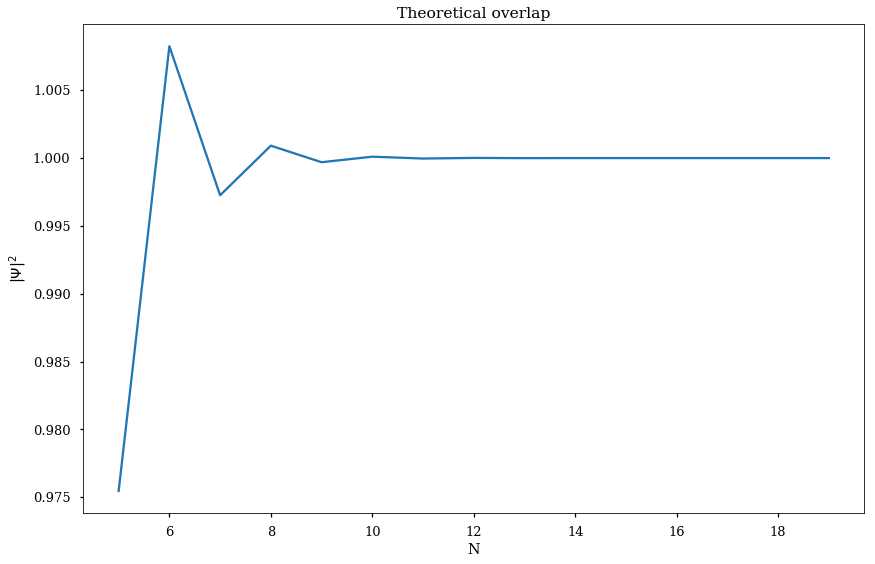

In [24]:
Nvals2 = np.arange(5,20,1)
overlaps_i =[]
for x_i in Nvals:
    one = trace(x_i)
    overlaps_i.append(one)
plt.plot(Nvals2, abs(np.array(overlaps_i)**2))
plt.xlabel("N")
plt.ylabel("$|\Psi|^2$")
plt.title("Theoretical overlap")

Text(0, 0.5, '$<S^{(j)} S^{(j+r)}>$')

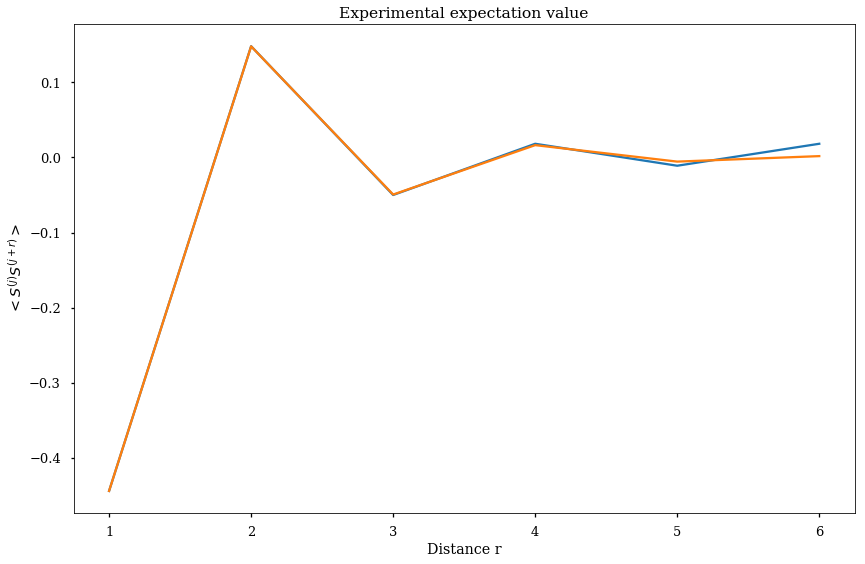

In [31]:
#calculating the overlap using the mps method
r=np.arange(1,7,1)
expectval=[]

for el in r:
    #2 as this is our first spin, el refers to the difference to the second element we are investigating and 10 is the
    #total spin number
    expectval.append(expect(2,el,10))

plt.plot(r,expectval)
plt.plot(r,SpinCorrelationTheo(4/3,r))
plt.title("Experimental expectation value")
plt.xlabel("Distance r")
plt.ylabel("$<S^{(j)} S^{(j+r)}>$")

Text(0.5, 1.0, 'theoretical expectation values')

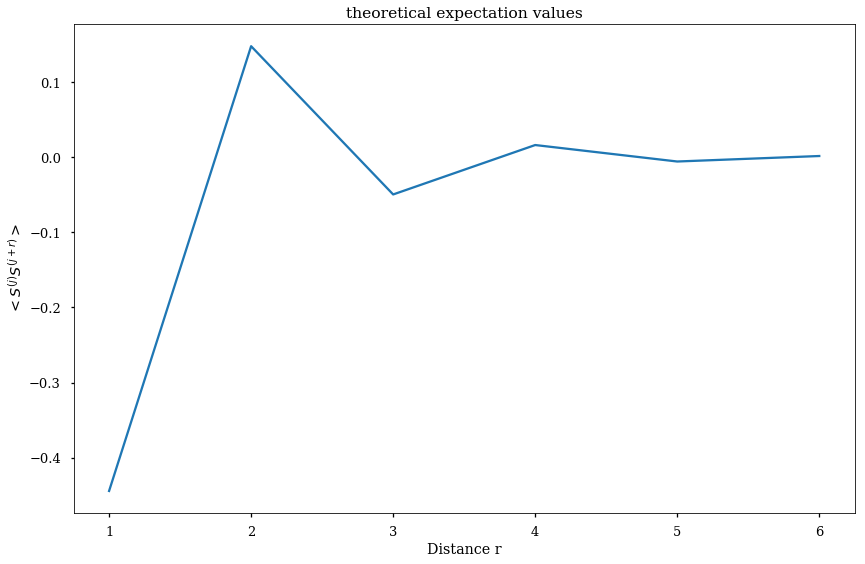

In [28]:
#theoretical values for reference
plt.plot(r,SpinCorrelationTheo(4/3,r))
plt.xlabel("Distance r")
plt.ylabel("$<S^{(j)} S^{(j+r)}>$")
plt.title("theoretical expectation values")